In [3]:
from soil.agents import FSM, state, default_state
from soil import Environment
from random import random, shuffle, sample
from itertools import islice
import logging
from enum import Enum
from random import randint
from soil import simulation
from soil import *
import soil
import networkx as nx
import matplotlib.pyplot as plt
import logging
import random
import numpy
logging.basicConfig()


/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [4]:
class Genders(Enum):
    male = 'male'
    female = 'female'

class Venues(Enum):
    pub = 'pub'
    disco = 'disco'
    street = 'street'


class CityPubs(Environment):

    """
    The environment is key in a simulation. It contains the network topology,
    a reference to network and environment agents, as well as the environment
    params, which are used as shared state between agents.
    The environment parameters and the state of every agent can be accessed
    both by using the environment as a dictionary or with the environment's 
    :meth:`soil.environment.Environment.get` method.
    'name': 'The awesome pub #{}'.format(i),
                'open': True,
                'capacity': pub_capacity ,
                'occupancy': 0,
                'price':randint(4, 6),
                'type': Venues.pub.value,
    """

    '''Environment with Pubs'''
    level = logging.INFO

    # ----------------------------------INICIALIZADOR----------------------------------------------------------------------------
    """def __init__(self, *args, number_of_pubs=3, number_of_discos=3, number_of_street=3, pub_capacity=10,
                 disco_capacity = 20, street_capacity = 30, **kwargs):
                    super(CityPubs, self).__init__(*args, **kwargs)  #Para la clase superior. Constructor super.
                    pubs = {}
                    for i in range(number_of_pubs):
                        newpub = {
                            'name': 'The awesome pub #{}'.format(i),
                            'open': True,
                            'capacity': pub_capacity ,
                            'occupancy': 0,
                            'price':randint(4, 6),
                            'type': Venues.pub.value,
                        }
                        pubs[newpub['name']] = newpub
                    for i in range(number_of_discos):
                        newpub = {
                            'name': 'The awesome disco #{}'.format(i),
                            'open': True,
                            'capacity': disco_capacity ,
                            'occupancy': 0,
                            'price':randint(7, 9),
                            'type': Venues.disco.value,
                        }
                        pubs[newpub['name']] = newpub
                    for i in range(number_of_street):
                        newpub = {
                            'name': 'The awesome street #{}'.format(i),
                            'open': True,
                            'capacity': pub_capacity ,
                            'occupancy': 0,
                            'price':randint(2,4),
                            'type': Venues.street.value,
                        }
                        pubs[newpub['name']] = newpub
            
                        
                    self['pubs'] = pubs"""


    def __init__(self, *args, pubs=None, **kwargs):
        super(CityPubs, self).__init__(*args, **kwargs)  #Para la clase superior. Constructor super.

            
        self['pubs'] = pubs or {}

        """ >>> tel = {'jack': 4098, 'sape': 4139}
            >>> tel['guido'] = 4127    
            >>> tel
            {'sape': 4139, 'guido': 4127, 'jack': 4098}"""

        #Hacemos un bucle y llenamos la variable pubs con los bares que va a haber: queda así:
            #{'The awesome pub #2': {'name': 'The awesome pub #2', 'open': True, 'capacity': 10, 'occupancy': 0}, 
            # 'The awesome pub #1': {'name': 'The awesome pub #1', 'open': True, 'capacity': 10, 'occupancy': 0}, 
            # 'The awesome pub #0': {'name': 'The awesome pub #0', 'open': True, 'capacity': 10, 'occupancy': 0}}


    #----------------------------------------MÉTODOS-------------------------------------------------------------------------------------
   

    def return_occupancy (self,pub_name):
        pub = self['pubs'][pub_name]
        return pub['occupancy']

    def return_price(self,pub_name):
        pub = self['pubs'][pub_name]
        return pub['price']

    def return_name(self,pub_name):
        pub = self['pubs'][pub_name]
        return pub['name']

    def return_type(self,pub_name):
        pub = self['pubs'][pub_name]
        return pub['type']




    def enter(self, pub_name, *nodes):

        '''Agents will try to enter. The pub checks if it is possible'''
        #A este método se le pasa el id del pub al que quieren entrar, y el grupo de amigos.
        #Hace comprobaciones con la capacidad y viendo si está abierto. Devuelve True si se puede entrar.

        try:
            pub = self['pubs'][pub_name]
        except KeyError:
            raise ValueError('Pub {} is not available'.format(pub_name))

        for node in nodes:
            if not pub['open'] or (pub['capacity'] < (len(nodes) + pub['occupancy'])) or node['money']< pub['entry']:

                return False

        pub['occupancy'] += len(nodes)
        for node in nodes:
            node['pub'] = pub_name
            node['money'] = node['money'] - pub['entry']
        return True


    #Devuelve una lista de pubs en los que se puede entrar. Lo hace con yield: se genera un objeto en vez de 
    # una lista. Cuando se llama al método no se genera la lista, se genera un objeto. SOlo cuando intentemos recorrerlo
    # se generará una lista que además solo puede recorrerse una vez --> https://stackoverflow.com/questions/231767/what-does-the-yield-keyword-do
    """def available_pubs(self):
                    
                    for pub in self['pubs'].values():
                        if pub['open'] and (pub['occupancy'] < pub['capacity']):
                            yield pub['name']"""

    def available_pubs_total(self):
        available_venues = []
        for pub in self['pubs'].values():
            if pub['open'] and (pub['occupancy'] < pub['capacity']):
                available_venues.append(pub['name'])

        shuffle(available_venues)
        return available_venues 

    def available_pubs(self):
        available_venues = []
        for pub in self['pubs'].values():
            if pub['open'] and (pub['occupancy'] < pub['capacity']) and pub['type'] == "pub":
                available_venues.append(pub['name'])

        shuffle(available_venues)
        return available_venues 

    def available_discos(self):
        available_venues = []
        for pub in self['pubs'].values():
            if pub['open'] and (pub['occupancy'] < pub['capacity']) and pub['type'] == "disco":
                available_venues.append(pub['name'])

        shuffle(available_venues)
        return available_venues 

    def available_street(self):
        available_venues = []
        for pub in self['pubs'].values():
            if pub['open'] and (pub['occupancy'] < pub['capacity']) and pub['type'] == "street":
                available_venues.append(pub['name'])

        shuffle(available_venues)
        return available_venues 

    #Un grupo se va de un pub. La sintaxis "del" es como decir que te vacíe esa variable
    """def exit(self, pub_id, *node_ids):
                    '''Agents will notify the pub they want to leave'''
                    try:
                        pub = self['pubs'][pub_id]
                    except KeyError:
                        raise ValueError('Pub {} is not available'.format(pub_id))
                    for node_id in node_ids:
                        node = self.get_agent(node_id)
                        if pub_id == node['pub']:
                            del node['pub']
                            pub['occupancy'] -= 1
            
                def exit(self, pub_id, *nodes):
                    '''Agents will notify the pub they want to leave'''
                    try:
                        pub = self['pubs'][pub_id]
                    except KeyError:
                        raise ValueError('Pub {} is not available'.format(pub_id))
                    for node in nodes:
                     
                        if pub_id == node['pub']:
                            del node['pub']
                            pub['occupancy'] -= 1
            """
    def exit(self, pub_name, *nodes):

        try:
            pub = self['pubs'][pub_name]
        except KeyError:
            raise ValueError('Pub {} is not available'.format(pub_name))
        
        pub['occupancy'] -= len(nodes)
        
        

In [5]:
class Patron(FSM):
    '''Agent that looks for friends to drink with. It will do three things:
        1) Look for other patrons to drink with
        2) Look for a bar where the agent and other agents in the same group can get in.
        3) While in the bar, patrons only drink, until they get drunk and taken home.
    '''
    level = logging.INFO

    defaults = {
        'pub': None,
        'drunk': False,
        'pints': 0,
        'max_pints': 5,
        'in_a_group':False,
        'gender': Genders.male.value,
        'money':20,
        'is_leader': False,
        'group_size':0,
        'total_changes':0,
        'num_of_changes':0,
        ##'interval'
    }

    @default_state
    @state
    def looking_for_friends(self):
        '''Look for friends to drink with'''

        if(self['in_a_group'] == False):
            self.info('I am looking for friends')
            self['is_leader'] = True
            self['num_of_changes'] = numpy.random.normal(5.9,2)
            available_friends = list(self.get_agents(drunk=False,
                                                     pub=None,
                                                     in_a_group=False))
                                                     
            if not available_friends or len(available_friends)==1:
                self.info('Life sucks and I\'m alone!')
                return self.at_home
            befriended = self.try_friends(available_friends)
            if befriended:
                
                return self.looking_for_pub#, self.env.timeout(3)
        else:
            self.info('{} has a group already' .format(self.id))
            return self.looking_for_pub

    @state
    def looking_for_pub(self):
        '''Look for a pub that accepts me and my friends'''
        if self['pub'] != None:
            return self.sober_in_pub
        self.debug('I am looking for a pub')
        group = list(self.get_neighboring_agents())

        r = random()

        if(self.env.get('prob_disco') > r):

            available_pubs = self.env.available_discos()

        elif((self.env.get('prob_pub') + self.env.get('prob_disco')) > r):

            available_pubs = self.env.available_pubs()

        else:

            available_pubs = self.env.available_street()



        for pub in available_pubs:


            self.debug('We\'re trying to get into {}: total: {}'.format(pub, len(group)))
            if self.env.enter(pub, self, *group):
                self.info('We\'re all {} getting in {}!'.format(len(group)+1, pub))
                capacity = self.env.return_occupancy(pub)
                self.info('{} now has {} people inside'.format(pub,capacity))
                return self.sober_in_pub
            else:
                self.info("We can\'t go inside {}".format(pub))

    @state
    def sober_in_pub(self):
        """Manipulamos prob_change_bar dependiendo de donde estén
                                Bar-->Disco probable
                                Bar-->Bar   bastante probable
                                Bar-->street probable
                                Street-->Bar probable
                                Street-->Disco probable
                                Street-->Street poco probable
                                Disco --> lo que sea poco probable(MIrar zonas como Nuit que hay varias discos)
                        
                                
                                Meter house para gente que copea en casa y luego va a discoteca?
                        
                        
                                
                                Meter que hagan distintos itinerarios y meter proporcion de gente en bar, botellon y discoteca.
                                En un futuro esto dependeŕa de la hora y la edad"""

        type = self.env.return_type(self['pub'])


        
        if(type=="disco"):
            self['prob_change_bar'] = 0.01


        else:
            #Street
            self['prob_change_bar'] = 0.4


        if self['is_leader'] and (self['prob_change_bar']>random() and self['total_changes']<self['num_of_changes']):
            self.change_bar()
            self['total_changes'] = self['total_changes']  + 1



        '''Drink up.'''
        self.drink()
        if self['pints'] > self['max_pints']:
            return self.drunk_in_pub

    @state
    def drunk_in_pub(self):
        '''I'm out. Take me home!'''
        self.info('I\'m so drunk. Take me home!')
        self['drunk'] = True
        pass  # out drunk

    @state
    def at_home(self):
        '''The end'''
        self.debug('Life sucks. I\'m home!')
    
    def change_bar(self):
        self.info('This member is going to change pub: {}'.format(self.id))

        current_pub = self['pub']

        group = list(self.get_neighboring_agents())

        available_pubs = self.env.available_pubs()

        for pub in available_pubs:
            if self.env.return_name(pub) != current_pub:
                self.debug('We\'re trying to get into {}: total: {}'.format(pub, len(group)))
                if self.env.enter(pub, self, *group):
                    self.env.exit(current_pub,self, *group)
                    self.info('We\'re all {} changing to {}!'.format(len(group)+1, pub))
                    capacity = self.env.return_occupancy(pub)
                    self.info('{} now has {} people inside'.format(pub,capacity))
                    
                    return
                    
                else:
                    self.info("We can\'t go inside {}".format(pub))
        

                    #COMPLETAR#-----------


    
    def drink(self):
        price = self.env.return_price(self['pub'])
        if(self['prob_drink']>random() and price<self['money']):
            self['pints'] += 1
            self['money'] -= price
            self.debug('Cheers to that')
            
            self.debug('The price is {} € at {}'.format(price,self['pub']))

    def kick_out(self):
        self.set_state(self.at_home)

    def befriend(self, other_agent):
        '''
        Try to become friends with another agent. The chances of
        success depend on both agents' openness.
        '''
       
        self.env.add_edge(self, other_agent)
        self.info('Made some friend, agent {}'.format(other_agent.id))
        return True
        

    def try_friends(self, others):
        ''' Look for random agents around me and try to befriend them'''
        n=1
        befriended = False
        k = numpy.random.poisson(5.69)#k = randint(4, 6)
        shuffle(others)
        for friend in islice(others, k):  # random.choice >= 3.7
            if friend == self:
                continue
            if friend.befriend(self):
                self.befriend(friend)
                self.info('Hooray! new friend: {}'.format(friend.id))
                n = n+1
                befriended = True
            else:
                self.info('{} does not want to be friends'.format(friend.id))

        self['in_a_group'] = True
        self['group_size'] = n
        neighbors_leader = list(self.get_neighboring_agents())

        #print(*neighbors_leader)
        
        for people in neighbors_leader:
            people['in_a_group'] = True
            people['group_size'] = n
            for i in neighbors_leader:
                if (people!=i):
                    people.befriend(i)
        
        return befriended
                        

In [6]:
class Police(FSM):
    '''Simple agent to take drunk people out of pubs.'''
    level = logging.INFO

    @default_state
    @state
    def patrol(self):
        drunksters = list(self.get_agents(drunk=True,
                                          state_id=Patron.drunk_in_pub.id))
        for drunk in drunksters:
            self.info('Kicking out the trash: {}'.format(drunk.id))
            drunk.kick_out()
        else:
            self.info('No trash to take out. Too bad.')

In [8]:
simulation.run_from_config('pubcrawl.yml',
                               
                               dump=None,
                               )



INFO:soil:Using config(s): Malasana
INFO:soil:Dumping results to soil_output/Malasana : False
INFO:soil:Starting simulation Malasana at 18:58:22.
INFO:soil:Starting Simulation Malasana trial 0 at 18:58:27.
INFO:Malasana_trial_0-Agent-Police:	@    0:	No trash to take out. Too bad.
INFO:Malasana_trial_0-Agent-0:	@    0:	I am looking for friends
INFO:Malasana_trial_0-Agent-249:	@    0:	Made some friend, agent 0
INFO:Malasana_trial_0-Agent-0:	@    0:	Made some friend, agent 249
INFO:Malasana_trial_0-Agent-0:	@    0:	Hooray! new friend: 249
INFO:Malasana_trial_0-Agent-26:	@    0:	Made some friend, agent 0
INFO:Malasana_trial_0-Agent-0:	@    0:	Made some friend, agent 26
INFO:Malasana_trial_0-Agent-0:	@    0:	Hooray! new friend: 26
INFO:Malasana_trial_0-Agent-65:	@    0:	Made some friend, agent 0
INFO:Malasana_trial_0-Agent-0:	@    0:	Made some friend, agent 65
INFO:Malasana_trial_0-Agent-0:	@    0:	Hooray! new friend: 65
INFO:Malasana_trial_0-Agent-232:	@    0:	Made some friend, agent 0
INF

INFO:Malasana_trial_0-Agent-188:	@    0:	Made some friend, agent 14
INFO:Malasana_trial_0-Agent-29:	@    0:	Made some friend, agent 49
INFO:Malasana_trial_0-Agent-29:	@    0:	Made some friend, agent 114
INFO:Malasana_trial_0-Agent-29:	@    0:	Made some friend, agent 68
INFO:Malasana_trial_0-Agent-29:	@    0:	Made some friend, agent 167
INFO:Malasana_trial_0-Agent-29:	@    0:	Made some friend, agent 200
INFO:Malasana_trial_0-Agent-29:	@    0:	Made some friend, agent 91
INFO:Malasana_trial_0-Agent-29:	@    0:	Made some friend, agent 188
INFO:Malasana_trial_0-Agent-29:	@    0:	Made some friend, agent 14
INFO:Malasana_trial_0-Agent-14:	@    0:	Made some friend, agent 49
INFO:Malasana_trial_0-Agent-14:	@    0:	Made some friend, agent 114
INFO:Malasana_trial_0-Agent-14:	@    0:	Made some friend, agent 68
INFO:Malasana_trial_0-Agent-14:	@    0:	Made some friend, agent 167
INFO:Malasana_trial_0-Agent-14:	@    0:	Made some friend, agent 200
INFO:Malasana_trial_0-Agent-14:	@    0:	Made some frie

INFO:Malasana_trial_0-Agent-204:	@    0:	Made some friend, agent 244
INFO:Malasana_trial_0-Agent-204:	@    0:	Made some friend, agent 134
INFO:Malasana_trial_0-Agent-204:	@    0:	Made some friend, agent 218
INFO:Malasana_trial_0-Agent-204:	@    0:	Made some friend, agent 201
INFO:Malasana_trial_0-Agent-204:	@    0:	Made some friend, agent 90
INFO:Malasana_trial_0-Agent-204:	@    0:	Made some friend, agent 123
INFO:Malasana_trial_0-Agent-204:	@    0:	Made some friend, agent 141
INFO:Malasana_trial_0-Agent-141:	@    0:	Made some friend, agent 145
INFO:Malasana_trial_0-Agent-141:	@    0:	Made some friend, agent 18
INFO:Malasana_trial_0-Agent-141:	@    0:	Made some friend, agent 244
INFO:Malasana_trial_0-Agent-141:	@    0:	Made some friend, agent 134
INFO:Malasana_trial_0-Agent-141:	@    0:	Made some friend, agent 218
INFO:Malasana_trial_0-Agent-141:	@    0:	Made some friend, agent 201
INFO:Malasana_trial_0-Agent-141:	@    0:	Made some friend, agent 90
INFO:Malasana_trial_0-Agent-141:	@   

INFO:Malasana_trial_0-Agent-58:	@    0:	Made some friend, agent 6
INFO:Malasana_trial_0-Agent-6:	@    0:	Made some friend, agent 58
INFO:Malasana_trial_0-Agent-6:	@    0:	Hooray! new friend: 58
INFO:Malasana_trial_0-Agent-150:	@    0:	Made some friend, agent 6
INFO:Malasana_trial_0-Agent-6:	@    0:	Made some friend, agent 150
INFO:Malasana_trial_0-Agent-6:	@    0:	Hooray! new friend: 150
INFO:Malasana_trial_0-Agent-181:	@    0:	Made some friend, agent 246
INFO:Malasana_trial_0-Agent-181:	@    0:	Made some friend, agent 247
INFO:Malasana_trial_0-Agent-181:	@    0:	Made some friend, agent 58
INFO:Malasana_trial_0-Agent-181:	@    0:	Made some friend, agent 150
INFO:Malasana_trial_0-Agent-181:	@    0:	Made some friend, agent 229
INFO:Malasana_trial_0-Agent-246:	@    0:	Made some friend, agent 181
INFO:Malasana_trial_0-Agent-246:	@    0:	Made some friend, agent 247
INFO:Malasana_trial_0-Agent-246:	@    0:	Made some friend, agent 58
INFO:Malasana_trial_0-Agent-246:	@    0:	Made some friend, 

INFO:Malasana_trial_0-Agent-8:	@    0:	Made some friend, agent 73
INFO:Malasana_trial_0-Agent-8:	@    0:	Hooray! new friend: 73
INFO:Malasana_trial_0-Agent-73:	@    0:	Made some friend, agent 227
INFO:Malasana_trial_0-Agent-227:	@    0:	Made some friend, agent 73
INFO:Malasana_trial_0-Agent-9:	@    0:	I am looking for friends
INFO:Malasana_trial_0-Agent-207:	@    0:	Made some friend, agent 9
INFO:Malasana_trial_0-Agent-9:	@    0:	Made some friend, agent 207
INFO:Malasana_trial_0-Agent-9:	@    0:	Hooray! new friend: 207
INFO:Malasana_trial_0-Agent-146:	@    0:	Made some friend, agent 9
INFO:Malasana_trial_0-Agent-9:	@    0:	Made some friend, agent 146
INFO:Malasana_trial_0-Agent-9:	@    0:	Hooray! new friend: 146
INFO:Malasana_trial_0-Agent-126:	@    0:	Made some friend, agent 9
INFO:Malasana_trial_0-Agent-9:	@    0:	Made some friend, agent 126
INFO:Malasana_trial_0-Agent-9:	@    0:	Hooray! new friend: 126
INFO:Malasana_trial_0-Agent-69:	@    0:	Made some friend, agent 9
INFO:Malasana_t

INFO:Malasana_trial_0-Agent-163:	@    0:	Made some friend, agent 199
INFO:Malasana_trial_0-Agent-163:	@    0:	Made some friend, agent 72
INFO:Malasana_trial_0-Agent-163:	@    0:	Made some friend, agent 170
INFO:Malasana_trial_0-Agent-163:	@    0:	Made some friend, agent 159
INFO:Malasana_trial_0-Agent-163:	@    0:	Made some friend, agent 53
INFO:Malasana_trial_0-Agent-163:	@    0:	Made some friend, agent 175
INFO:Malasana_trial_0-Agent-245:	@    0:	Made some friend, agent 224
INFO:Malasana_trial_0-Agent-245:	@    0:	Made some friend, agent 163
INFO:Malasana_trial_0-Agent-245:	@    0:	Made some friend, agent 182
INFO:Malasana_trial_0-Agent-245:	@    0:	Made some friend, agent 199
INFO:Malasana_trial_0-Agent-245:	@    0:	Made some friend, agent 72
INFO:Malasana_trial_0-Agent-245:	@    0:	Made some friend, agent 170
INFO:Malasana_trial_0-Agent-245:	@    0:	Made some friend, agent 159
INFO:Malasana_trial_0-Agent-245:	@    0:	Made some friend, agent 53
INFO:Malasana_trial_0-Agent-245:	@    

INFO:Malasana_trial_0-Agent-152:	@    0:	Made some friend, agent 186
INFO:Malasana_trial_0-Agent-152:	@    0:	Made some friend, agent 171
INFO:Malasana_trial_0-Agent-152:	@    0:	Made some friend, agent 117
INFO:Malasana_trial_0-Agent-152:	@    0:	Made some friend, agent 95
INFO:Malasana_trial_0-Agent-41:	@    0:	Made some friend, agent 147
INFO:Malasana_trial_0-Agent-41:	@    0:	Made some friend, agent 213
INFO:Malasana_trial_0-Agent-41:	@    0:	Made some friend, agent 152
INFO:Malasana_trial_0-Agent-41:	@    0:	Made some friend, agent 186
INFO:Malasana_trial_0-Agent-41:	@    0:	Made some friend, agent 171
INFO:Malasana_trial_0-Agent-41:	@    0:	Made some friend, agent 117
INFO:Malasana_trial_0-Agent-41:	@    0:	Made some friend, agent 95
INFO:Malasana_trial_0-Agent-186:	@    0:	Made some friend, agent 147
INFO:Malasana_trial_0-Agent-186:	@    0:	Made some friend, agent 213
INFO:Malasana_trial_0-Agent-186:	@    0:	Made some friend, agent 152
INFO:Malasana_trial_0-Agent-186:	@    0:	Ma

INFO:Malasana_trial_0-Agent-226:	@    0:	Made some friend, agent 47
INFO:Malasana_trial_0-Agent-133:	@    0:	Made some friend, agent 226
INFO:Malasana_trial_0-Agent-133:	@    0:	Made some friend, agent 102
INFO:Malasana_trial_0-Agent-133:	@    0:	Made some friend, agent 77
INFO:Malasana_trial_0-Agent-133:	@    0:	Made some friend, agent 46
INFO:Malasana_trial_0-Agent-133:	@    0:	Made some friend, agent 47
INFO:Malasana_trial_0-Agent-102:	@    0:	Made some friend, agent 226
INFO:Malasana_trial_0-Agent-102:	@    0:	Made some friend, agent 133
INFO:Malasana_trial_0-Agent-102:	@    0:	Made some friend, agent 77
INFO:Malasana_trial_0-Agent-102:	@    0:	Made some friend, agent 46
INFO:Malasana_trial_0-Agent-102:	@    0:	Made some friend, agent 47
INFO:Malasana_trial_0-Agent-77:	@    0:	Made some friend, agent 226
INFO:Malasana_trial_0-Agent-77:	@    0:	Made some friend, agent 133
INFO:Malasana_trial_0-Agent-77:	@    0:	Made some friend, agent 102
INFO:Malasana_trial_0-Agent-77:	@    0:	Made

INFO:Malasana_trial_0-Agent-88:	@    0:	Made some friend, agent 216
INFO:Malasana_trial_0-Agent-88:	@    0:	Made some friend, agent 148
INFO:Malasana_trial_0-Agent-88:	@    0:	Made some friend, agent 85
INFO:Malasana_trial_0-Agent-88:	@    0:	Made some friend, agent 198
INFO:Malasana_trial_0-Agent-88:	@    0:	Made some friend, agent 151
INFO:Malasana_trial_0-Agent-88:	@    0:	Made some friend, agent 44
INFO:Malasana_trial_0-Agent-88:	@    0:	Made some friend, agent 43
INFO:Malasana_trial_0-Agent-88:	@    0:	Made some friend, agent 28
INFO:Malasana_trial_0-Agent-88:	@    0:	Made some friend, agent 129
INFO:Malasana_trial_0-Agent-44:	@    0:	Made some friend, agent 176
INFO:Malasana_trial_0-Agent-44:	@    0:	Made some friend, agent 216
INFO:Malasana_trial_0-Agent-44:	@    0:	Made some friend, agent 148
INFO:Malasana_trial_0-Agent-44:	@    0:	Made some friend, agent 85
INFO:Malasana_trial_0-Agent-44:	@    0:	Made some friend, agent 198
INFO:Malasana_trial_0-Agent-44:	@    0:	Made some fri

INFO:Malasana_trial_0-Agent-45:	@    0:	Made some friend, agent 135
INFO:Malasana_trial_0-Agent-135:	@    0:	Made some friend, agent 165
INFO:Malasana_trial_0-Agent-135:	@    0:	Made some friend, agent 180
INFO:Malasana_trial_0-Agent-135:	@    0:	Made some friend, agent 45
INFO:Malasana_trial_0-Agent-25:	@    0:	25 has a group already
INFO:Malasana_trial_0-Agent-26:	@    0:	26 has a group already
INFO:Malasana_trial_0-Agent-27:	@    0:	27 has a group already
INFO:Malasana_trial_0-Agent-28:	@    0:	28 has a group already
INFO:Malasana_trial_0-Agent-29:	@    0:	29 has a group already
INFO:Malasana_trial_0-Agent-30:	@    0:	I am looking for friends
INFO:Malasana_trial_0-Agent-76:	@    0:	Made some friend, agent 30
INFO:Malasana_trial_0-Agent-30:	@    0:	Made some friend, agent 76
INFO:Malasana_trial_0-Agent-30:	@    0:	Hooray! new friend: 76
INFO:Malasana_trial_0-Agent-50:	@    0:	Made some friend, agent 30
INFO:Malasana_trial_0-Agent-30:	@    0:	Made some friend, agent 50
INFO:Malasana_t

INFO:Malasana_trial_0-Agent-34:	@    0:	Made some friend, agent 48
INFO:Malasana_trial_0-Agent-34:	@    0:	Hooray! new friend: 48
INFO:Malasana_trial_0-Agent-38:	@    0:	Made some friend, agent 34
INFO:Malasana_trial_0-Agent-34:	@    0:	Made some friend, agent 38
INFO:Malasana_trial_0-Agent-34:	@    0:	Hooray! new friend: 38
INFO:Malasana_trial_0-Agent-67:	@    0:	Made some friend, agent 34
INFO:Malasana_trial_0-Agent-34:	@    0:	Made some friend, agent 67
INFO:Malasana_trial_0-Agent-34:	@    0:	Hooray! new friend: 67
INFO:Malasana_trial_0-Agent-157:	@    0:	Made some friend, agent 34
INFO:Malasana_trial_0-Agent-34:	@    0:	Made some friend, agent 157
INFO:Malasana_trial_0-Agent-34:	@    0:	Hooray! new friend: 157
INFO:Malasana_trial_0-Agent-230:	@    0:	Made some friend, agent 34
INFO:Malasana_trial_0-Agent-34:	@    0:	Made some friend, agent 230
INFO:Malasana_trial_0-Agent-34:	@    0:	Hooray! new friend: 230
INFO:Malasana_trial_0-Agent-112:	@    0:	Made some friend, agent 48
INFO:Mal

INFO:Malasana_trial_0-Agent-55:	@    0:	Made some friend, agent 39
INFO:Malasana_trial_0-Agent-39:	@    0:	Made some friend, agent 55
INFO:Malasana_trial_0-Agent-39:	@    0:	Hooray! new friend: 55
INFO:Malasana_trial_0-Agent-96:	@    0:	Made some friend, agent 169
INFO:Malasana_trial_0-Agent-96:	@    0:	Made some friend, agent 101
INFO:Malasana_trial_0-Agent-96:	@    0:	Made some friend, agent 142
INFO:Malasana_trial_0-Agent-96:	@    0:	Made some friend, agent 55
INFO:Malasana_trial_0-Agent-169:	@    0:	Made some friend, agent 96
INFO:Malasana_trial_0-Agent-169:	@    0:	Made some friend, agent 101
INFO:Malasana_trial_0-Agent-169:	@    0:	Made some friend, agent 142
INFO:Malasana_trial_0-Agent-169:	@    0:	Made some friend, agent 55
INFO:Malasana_trial_0-Agent-101:	@    0:	Made some friend, agent 96
INFO:Malasana_trial_0-Agent-101:	@    0:	Made some friend, agent 169
INFO:Malasana_trial_0-Agent-101:	@    0:	Made some friend, agent 142
INFO:Malasana_trial_0-Agent-101:	@    0:	Made some f

INFO:Malasana_trial_0-Agent-194:	@    0:	Made some friend, agent 70
INFO:Malasana_trial_0-Agent-194:	@    0:	Made some friend, agent 118
INFO:Malasana_trial_0-Agent-194:	@    0:	Made some friend, agent 196
INFO:Malasana_trial_0-Agent-194:	@    0:	Made some friend, agent 237
INFO:Malasana_trial_0-Agent-194:	@    0:	Made some friend, agent 63
INFO:Malasana_trial_0-Agent-195:	@    0:	Made some friend, agent 144
INFO:Malasana_trial_0-Agent-195:	@    0:	Made some friend, agent 160
INFO:Malasana_trial_0-Agent-195:	@    0:	Made some friend, agent 194
INFO:Malasana_trial_0-Agent-195:	@    0:	Made some friend, agent 212
INFO:Malasana_trial_0-Agent-195:	@    0:	Made some friend, agent 70
INFO:Malasana_trial_0-Agent-195:	@    0:	Made some friend, agent 118
INFO:Malasana_trial_0-Agent-195:	@    0:	Made some friend, agent 196
INFO:Malasana_trial_0-Agent-195:	@    0:	Made some friend, agent 237
INFO:Malasana_trial_0-Agent-195:	@    0:	Made some friend, agent 63
INFO:Malasana_trial_0-Agent-212:	@    

INFO:Malasana_trial_0-Agent-63:	@    0:	63 has a group already
INFO:Malasana_trial_0-Agent-64:	@    0:	64 has a group already
INFO:Malasana_trial_0-Agent-65:	@    0:	65 has a group already
INFO:Malasana_trial_0-Agent-66:	@    0:	66 has a group already
INFO:Malasana_trial_0-Agent-67:	@    0:	67 has a group already
INFO:Malasana_trial_0-Agent-68:	@    0:	68 has a group already
INFO:Malasana_trial_0-Agent-69:	@    0:	69 has a group already
INFO:Malasana_trial_0-Agent-70:	@    0:	70 has a group already
INFO:Malasana_trial_0-Agent-71:	@    0:	I am looking for friends
INFO:Malasana_trial_0-Agent-190:	@    0:	Made some friend, agent 71
INFO:Malasana_trial_0-Agent-71:	@    0:	Made some friend, agent 190
INFO:Malasana_trial_0-Agent-71:	@    0:	Hooray! new friend: 190
INFO:Malasana_trial_0-Agent-219:	@    0:	Made some friend, agent 71
INFO:Malasana_trial_0-Agent-71:	@    0:	Made some friend, agent 219
INFO:Malasana_trial_0-Agent-71:	@    0:	Hooray! new friend: 219
INFO:Malasana_trial_0-Agent-219

INFO:Malasana_trial_0-Agent-103:	@    0:	Made some friend, agent 130
INFO:Malasana_trial_0-Agent-103:	@    0:	Made some friend, agent 164
INFO:Malasana_trial_0-Agent-103:	@    0:	Made some friend, agent 140
INFO:Malasana_trial_0-Agent-103:	@    0:	Made some friend, agent 189
INFO:Malasana_trial_0-Agent-140:	@    0:	Made some friend, agent 192
INFO:Malasana_trial_0-Agent-140:	@    0:	Made some friend, agent 177
INFO:Malasana_trial_0-Agent-140:	@    0:	Made some friend, agent 130
INFO:Malasana_trial_0-Agent-140:	@    0:	Made some friend, agent 164
INFO:Malasana_trial_0-Agent-140:	@    0:	Made some friend, agent 103
INFO:Malasana_trial_0-Agent-140:	@    0:	Made some friend, agent 189
INFO:Malasana_trial_0-Agent-189:	@    0:	Made some friend, agent 192
INFO:Malasana_trial_0-Agent-189:	@    0:	Made some friend, agent 177
INFO:Malasana_trial_0-Agent-189:	@    0:	Made some friend, agent 130
INFO:Malasana_trial_0-Agent-189:	@    0:	Made some friend, agent 164
INFO:Malasana_trial_0-Agent-189:	@

INFO:Malasana_trial_0-Agent-89:	@    0:	89 has a group already
INFO:Malasana_trial_0-Agent-90:	@    0:	90 has a group already
INFO:Malasana_trial_0-Agent-91:	@    0:	91 has a group already
INFO:Malasana_trial_0-Agent-92:	@    0:	92 has a group already
INFO:Malasana_trial_0-Agent-93:	@    0:	I am looking for friends
INFO:Malasana_trial_0-Agent-106:	@    0:	Made some friend, agent 93
INFO:Malasana_trial_0-Agent-93:	@    0:	Made some friend, agent 106
INFO:Malasana_trial_0-Agent-93:	@    0:	Hooray! new friend: 106
INFO:Malasana_trial_0-Agent-108:	@    0:	Made some friend, agent 93
INFO:Malasana_trial_0-Agent-93:	@    0:	Made some friend, agent 108
INFO:Malasana_trial_0-Agent-93:	@    0:	Hooray! new friend: 108
INFO:Malasana_trial_0-Agent-208:	@    0:	Made some friend, agent 93
INFO:Malasana_trial_0-Agent-93:	@    0:	Made some friend, agent 208
INFO:Malasana_trial_0-Agent-93:	@    0:	Hooray! new friend: 208
INFO:Malasana_trial_0-Agent-208:	@    0:	Made some friend, agent 106
INFO:Malasana_

INFO:Malasana_trial_0-Agent-108:	@    0:	108 has a group already
INFO:Malasana_trial_0-Agent-109:	@    0:	109 has a group already
INFO:Malasana_trial_0-Agent-110:	@    0:	110 has a group already
INFO:Malasana_trial_0-Agent-111:	@    0:	111 has a group already
INFO:Malasana_trial_0-Agent-112:	@    0:	112 has a group already
INFO:Malasana_trial_0-Agent-113:	@    0:	113 has a group already
INFO:Malasana_trial_0-Agent-114:	@    0:	114 has a group already
INFO:Malasana_trial_0-Agent-115:	@    0:	115 has a group already
INFO:Malasana_trial_0-Agent-116:	@    0:	116 has a group already
INFO:Malasana_trial_0-Agent-117:	@    0:	117 has a group already
INFO:Malasana_trial_0-Agent-118:	@    0:	118 has a group already
INFO:Malasana_trial_0-Agent-119:	@    0:	119 has a group already
INFO:Malasana_trial_0-Agent-120:	@    0:	120 has a group already
INFO:Malasana_trial_0-Agent-121:	@    0:	121 has a group already
INFO:Malasana_trial_0-Agent-122:	@    0:	122 has a group already
INFO:Malasana_trial_0-Age

INFO:Malasana_trial_0-Agent-235:	@    0:	235 has a group already
INFO:Malasana_trial_0-Agent-236:	@    0:	236 has a group already
INFO:Malasana_trial_0-Agent-237:	@    0:	237 has a group already
INFO:Malasana_trial_0-Agent-238:	@    0:	238 has a group already
INFO:Malasana_trial_0-Agent-239:	@    0:	239 has a group already
INFO:Malasana_trial_0-Agent-240:	@    0:	240 has a group already
INFO:Malasana_trial_0-Agent-241:	@    0:	241 has a group already
INFO:Malasana_trial_0-Agent-242:	@    0:	242 has a group already
INFO:Malasana_trial_0-Agent-243:	@    0:	243 has a group already
INFO:Malasana_trial_0-Agent-244:	@    0:	244 has a group already
INFO:Malasana_trial_0-Agent-245:	@    0:	245 has a group already
INFO:Malasana_trial_0-Agent-246:	@    0:	246 has a group already
INFO:Malasana_trial_0-Agent-247:	@    0:	247 has a group already
INFO:Malasana_trial_0-Agent-248:	@    0:	248 has a group already
INFO:Malasana_trial_0-Agent-249:	@    0:	249 has a group already
INFO:Malasana_trial_0-Age

INFO:Malasana_trial_0-Agent-15:	@    4:	We're all 5 changing to Space Monkey!
INFO:Malasana_trial_0-Agent-15:	@    4:	Space Monkey now has 23 people inside
INFO:Malasana_trial_0-Agent-Police:	@    5:	No trash to take out. Too bad.
INFO:Malasana_trial_0-Agent-11:	@    5:	This member is going to change pub: 11
INFO:Malasana_trial_0-Agent-11:	@    5:	We're all 11 changing to Chupitos!
INFO:Malasana_trial_0-Agent-11:	@    5:	Chupitos now has 15 people inside
INFO:Malasana_trial_0-Agent-15:	@    5:	This member is going to change pub: 15
INFO:Malasana_trial_0-Agent-15:	@    5:	We're all 5 changing to Via Lactea!
INFO:Malasana_trial_0-Agent-15:	@    5:	Via Lactea now has 11 people inside
INFO:Malasana_trial_0-Agent-54:	@    5:	This member is going to change pub: 54
INFO:Malasana_trial_0-Agent-54:	@    5:	We're all 4 changing to Via Lactea!
INFO:Malasana_trial_0-Agent-54:	@    5:	Via Lactea now has 15 people inside
INFO:Malasana_trial_0-Agent-94:	@    5:	This member is going to change pub: 94


INFO:Malasana_trial_0-Agent-54:	@   13:	Chupitos now has 24 people inside
INFO:Malasana_trial_0-Agent-57:	@   13:	This member is going to change pub: 57
INFO:Malasana_trial_0-Agent-57:	@   13:	We're all 11 changing to Teleco!
INFO:Malasana_trial_0-Agent-57:	@   13:	Teleco now has 11 people inside
INFO:Malasana_trial_0-Agent-94:	@   13:	This member is going to change pub: 94
INFO:Malasana_trial_0-Agent-94:	@   13:	We're all 9 changing to Baile!
INFO:Malasana_trial_0-Agent-94:	@   13:	Baile now has 16 people inside
INFO:Malasana_trial_0-Agent-Police:	@   14:	No trash to take out. Too bad.
INFO:Malasana_trial_0-Agent-11:	@   14:	This member is going to change pub: 11
INFO:Malasana_trial_0-Agent-11:	@   14:	We're all 11 changing to Teleco!
INFO:Malasana_trial_0-Agent-11:	@   14:	Teleco now has 22 people inside
INFO:Malasana_trial_0-Agent-35:	@   14:	This member is going to change pub: 35
INFO:Malasana_trial_0-Agent-35:	@   14:	We're all 6 changing to Baile!
INFO:Malasana_trial_0-Agent-35:	

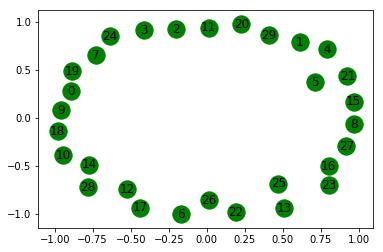

In [6]:
U = nx.empty_graph(30);
pos = nx.spring_layout(U);
nx.draw_networkx(U, pos, node_color='green');

[4 6 8 ... 2 6 6]


/home/alberto/.local/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6571: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


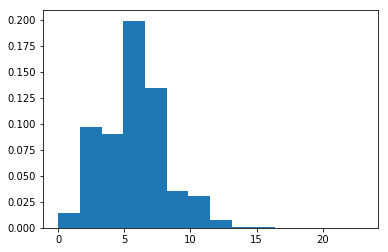

In [15]:
x = numpy.random.poisson(5.69, 20000000)
print(x)
count, bins, ignored = plt.hist(x, 14, normed=True)
plt.show()

[0.13571633 0.07381465 0.07234223 ... 0.14328325 0.06204736 0.07586213]


/home/alberto/.local/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6571: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


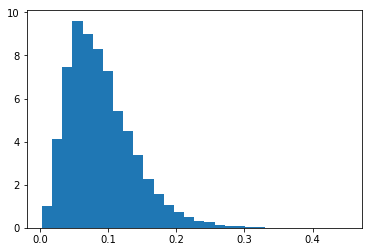

In [39]:
x = numpy.random.gamma(3.456,0.026,20000)
print(x)
count, bins, ignored = plt.hist(x, 30, normed=True)
plt.show()

[8.0, 4.0, 4.0, 6.0, 6.0, 5.0, 4.0, 7.0, 7.0, 5.0, 8.0, 6.0, 9.0, 6.0, 5.0, 5.0, 6.0, 6.0, 6.0, 7.0]


/home/alberto/.local/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6571: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


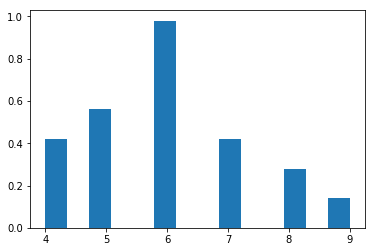

In [23]:
x = numpy.random.normal(5.9,2,20)
y = []
n=0
for i in x:
    i = round(i)
    y.append(i)
    n = n+1
    
print(y)
count, bins, ignored = plt.hist(y, 14, normed=True)
plt.show()

[4, 3, 7, 4, 3, 6, 6, 4, 5, 5, 5, 3, 3, 4, 4, 3, 7, 4, 6, 4, 4, 4, 3, 5, 4]


/home/alberto/.local/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6571: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


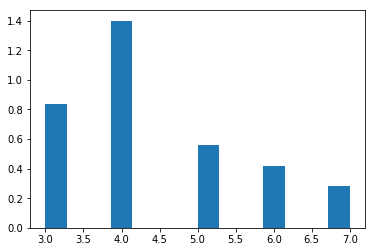

In [24]:
x= [4,
3,
7,
4,
3,
6,
6,
4,
5,
5,
5,
3,
3,
4,
4,
3,
7,
4,
6,
4,
4,
4,
3,
5,
4]
print(x)
count, bins, ignored = plt.hist(x, 14, normed=True)
plt.show()


In [9]:
from soil import history

In [10]:
list(h.to_tuples())

NameError: name 'h' is not defined